# Importing libraries

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# Loading Data

In [9]:
df = pd.read_csv('/kaggle/input/datasetev/ElectricCarData_Clean.csv')

# Display first 5 rows
df.head()


,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


# PreProcessing Data

In [10]:
# Check basic information
df.info()
# Summary statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 11.4+ KB


,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,7.000000,215000.000000


In [11]:
# Check missing values
df.isnull().sum()
# Fill numerical missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical missing values with mode
df.fillna(df.mode().iloc[0], inplace=True)


In [12]:
# Convert categorical columns to 'category' type
categorical_cols = ['Brand', 'Model', 'PowerTrain', 'PlugType', 'BodyStyle', 'Segment']
df[categorical_cols] = df[categorical_cols].astype('category')

df.dtypes


Brand              category
Model              category
AccelSec            float64
TopSpeed_KmH          int64
Range_Km              int64
Efficiency_WhKm       int64
FastCharge_KmH       object
RapidCharge          object
PowerTrain         category
PlugType           category
BodyStyle          category
Segment            category
Seats                 int64
PriceEuro             int64
dtype: object

# Removing Outliers

In [14]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers only from numerical columns
df_clean = df.copy()
df_clean = df_clean[~((df_clean[numerical_cols] < lower_bound) | (df_clean[numerical_cols] > upper_bound)).any(axis=1)]

print(f"Original size: {df.shape}, After outlier removal: {df_clean.shape}")


Original size: (103, 14), After outlier removal: (67, 14)


# Visualization & Analytics

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


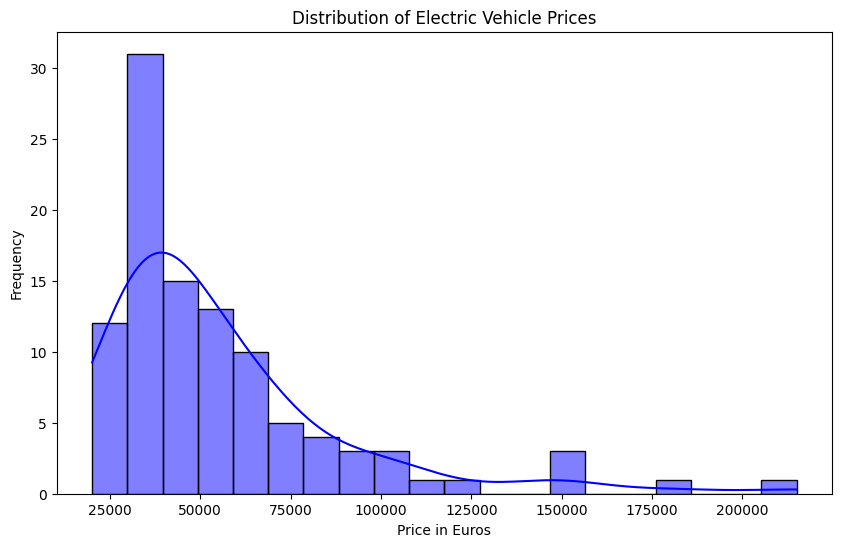

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['PriceEuro'], bins=20, kde=True, color='blue')
plt.title('Distribution of Electric Vehicle Prices')
plt.xlabel('Price in Euros')
plt.ylabel('Frequency')
plt.show()


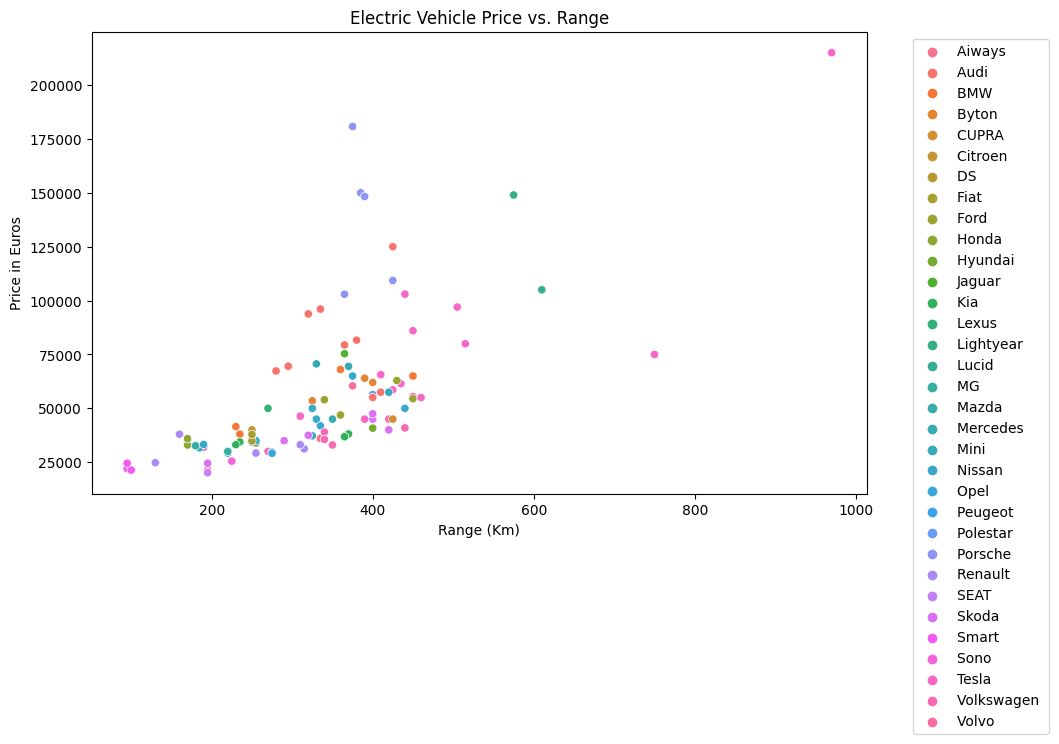

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Range_Km'], y=df['PriceEuro'], hue=df['Brand'])
plt.title('Electric Vehicle Price vs. Range')
plt.xlabel('Range (Km)')
plt.ylabel('Price in Euros')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


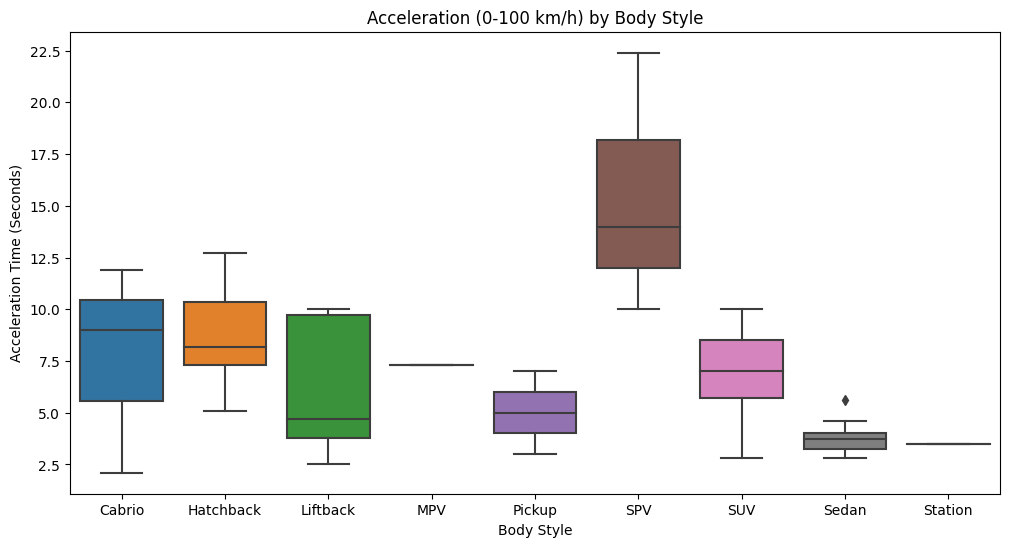

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='BodyStyle', y='AccelSec', data=df)
plt.title('Acceleration (0-100 km/h) by Body Style')
plt.xlabel('Body Style')
plt.ylabel('Acceleration Time (Seconds)')
plt.show()


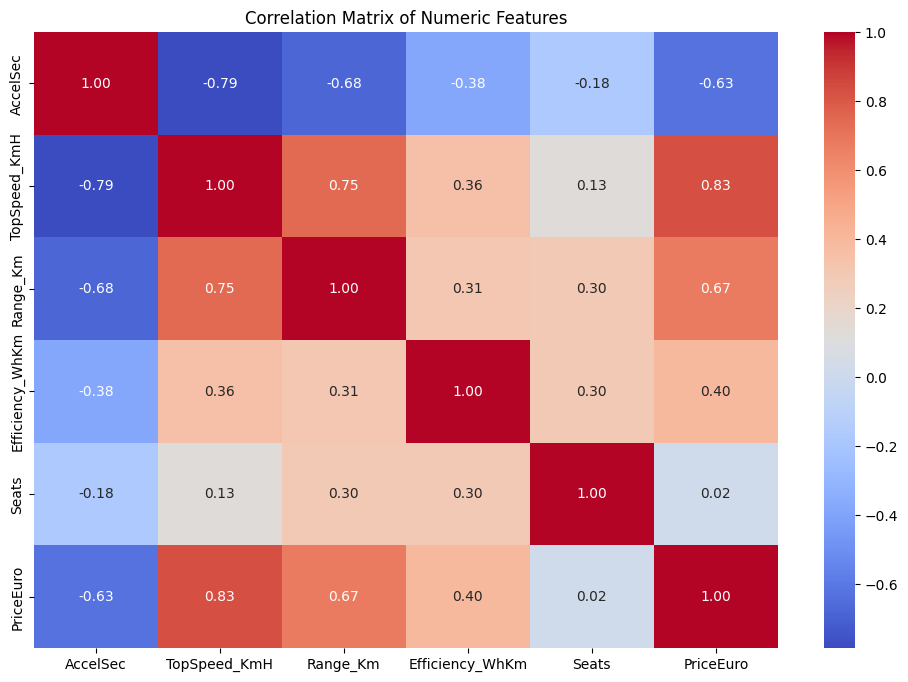

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


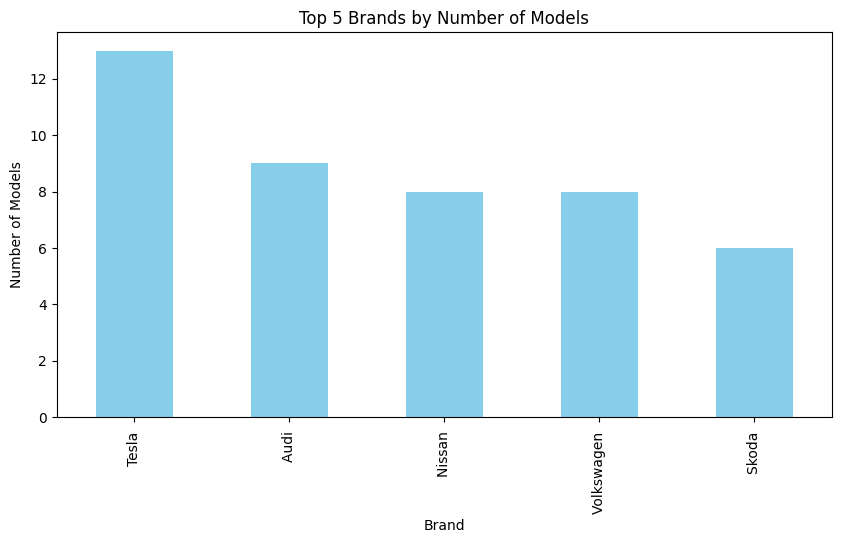

In [19]:
plt.figure(figsize=(10, 5))
df['Brand'].value_counts().nlargest(5).plot(kind='bar', color='skyblue')
plt.title('Top 5 Brands by Number of Models')
plt.ylabel('Number of Models')
plt.show()


In [20]:
df.nlargest(10, 'Range_Km')[['Brand', 'Model', 'Range_Km']]


,Brand,Model,Range_Km
51,Tesla,Roadster,970
33,Tesla,Cybertruck Tri Motor,750
5,Lucid,Air,610
48,Lightyear,One,575
40,Tesla,Model S Long Range,515
59,Tesla,Model S Performance,505
67,Tesla,Cybertruck Dual Motor,460
0,Tesla,Model 3 Long Range Dual Motor,450
13,BMW,i4,450
54,Tesla,Model X Long Range,450


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


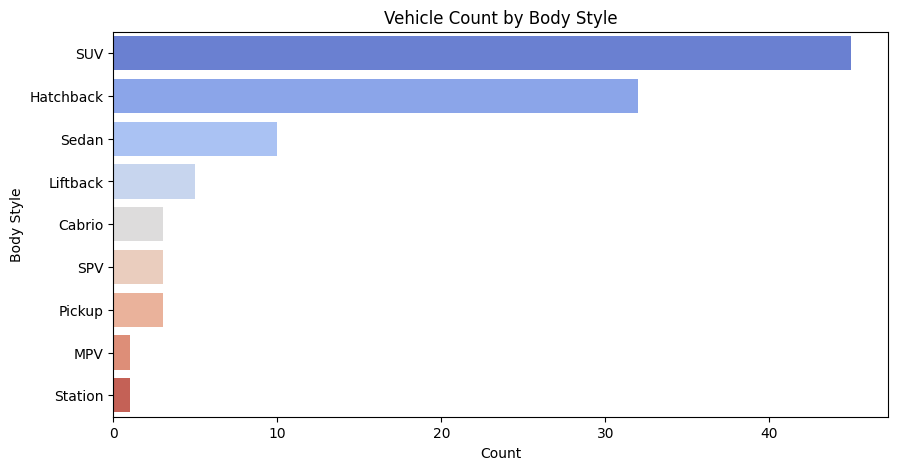

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(y=df['BodyStyle'], palette='coolwarm', order=df['BodyStyle'].value_counts().index)
plt.title('Vehicle Count by Body Style')
plt.xlabel('Count')
plt.ylabel('Body Style')
plt.show()


In [22]:
df.nsmallest(10, 'AccelSec')[['Brand', 'Model', 'AccelSec']]


,Brand,Model,AccelSec
51,Tesla,Roadster,2.1
59,Tesla,Model S Performance,2.5
5,Lucid,Air,2.8
16,Porsche,Taycan Turbo S,2.8
81,Tesla,Model X Performance,2.8
33,Tesla,Cybertruck Tri Motor,3.0
79,Porsche,Taycan Turbo,3.2
24,Tesla,Model 3 Long Range Performance,3.4
23,Audi,e-tron GT,3.5
72,Porsche,Taycan Cross Turismo,3.5


<ipython-input-23-9a898caad871>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Segment')['PriceEuro'].mean().sort_values().plot(kind='barh', color='green')


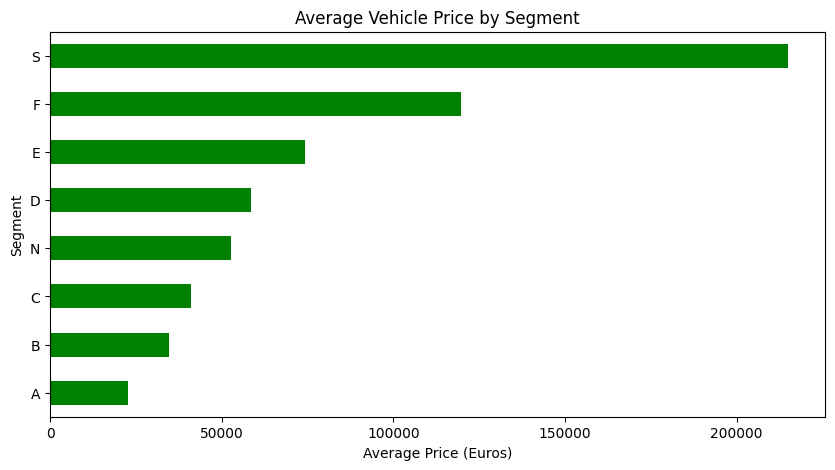

In [23]:
plt.figure(figsize=(10, 5))
df.groupby('Segment')['PriceEuro'].mean().sort_values().plot(kind='barh', color='green')
plt.title('Average Vehicle Price by Segment')
plt.xlabel('Average Price (Euros)')
plt.ylabel('Segment')
plt.show()


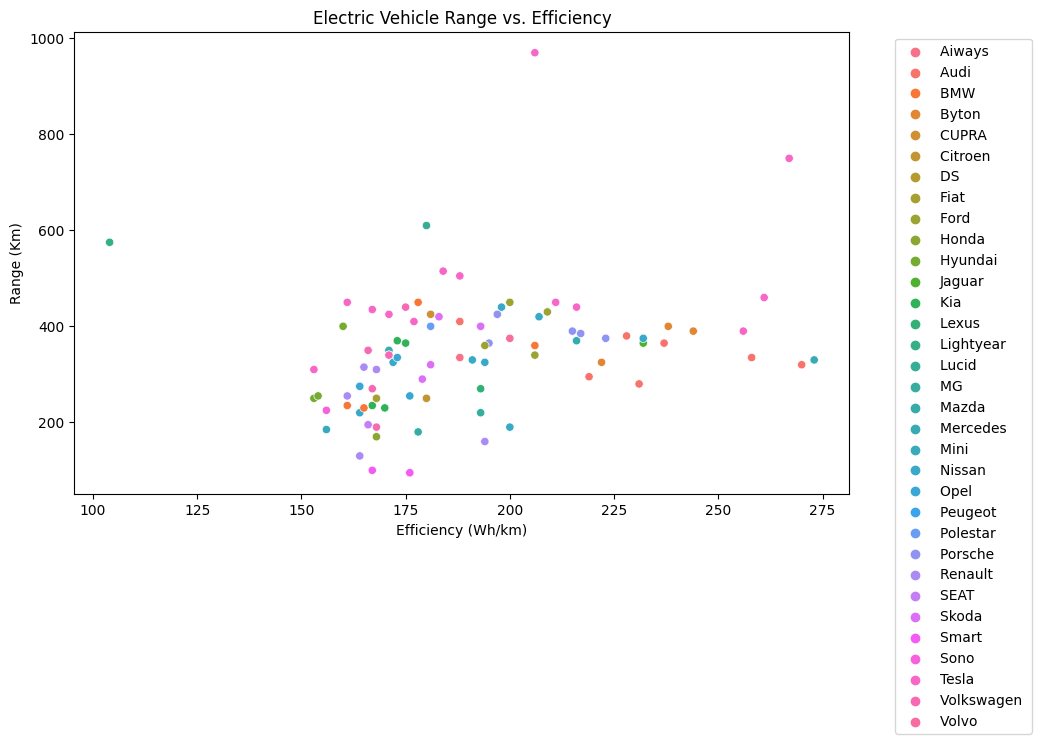

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Efficiency_WhKm'], y=df['Range_Km'], hue=df['Brand'])
plt.title('Electric Vehicle Range vs. Efficiency')
plt.xlabel('Efficiency (Wh/km)')
plt.ylabel('Range (Km)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [25]:
X = df[['Range_Km']]
y = df['PriceEuro']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))


Mean Absolute Error: 24075.936432995695
R-squared Score: -0.235637033015496


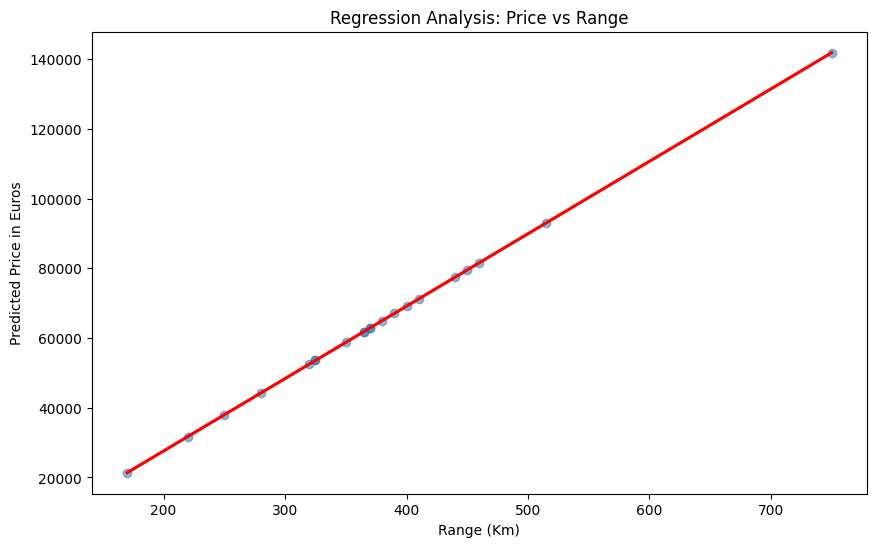

In [26]:
plt.figure(figsize=(10, 6))
sns.regplot(x=X_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression Analysis: Price vs Range')
plt.xlabel('Range (Km)')
plt.ylabel('Predicted Price in Euros')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


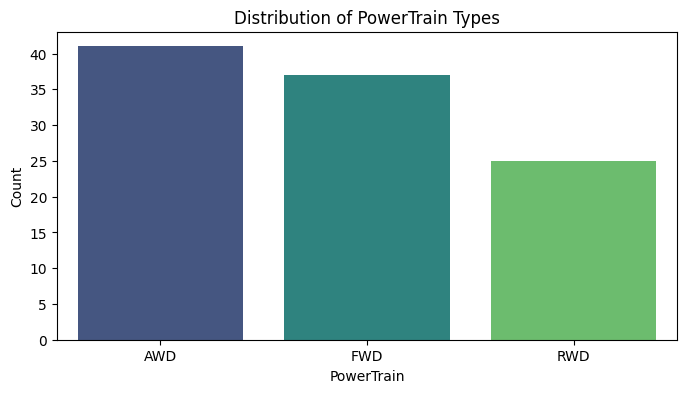

In [27]:
plt.figure(figsize=(8, 4))
sns.countplot(x='PowerTrain', data=df, palette='viridis')
plt.title('Distribution of PowerTrain Types')
plt.xlabel('PowerTrain')
plt.ylabel('Count')
plt.show()


In [28]:
df_fastcharge = df[df['RapidCharge'] == 'Yes']
df_fastcharge[['Brand', 'Model', 'Range_Km', 'FastCharge_KmH']].sort_values(by='FastCharge_KmH', ascending=False).head(10)


,Brand,Model,Range_Km,FastCharge_KmH
0,Tesla,Model 3 Long Range Dual Motor,450,940
21,Tesla,Model Y Long Range Dual Motor,425,930
51,Tesla,Roadster,970,920
24,Tesla,Model 3 Long Range Performance,435,910
61,Tesla,Model Y Long Range Performance,410,900
65,Porsche,Taycan 4S Plus,425,890
23,Audi,e-tron GT,425,850
79,Porsche,Taycan Turbo,390,810
16,Porsche,Taycan Turbo S,375,780
72,Porsche,Taycan Cross Turismo,385,770


In [29]:
# Import required library
from scipy.stats import skew

# Compute skewness for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
skew_values = df[numerical_cols].apply(skew, nan_policy='omit')

# Display skewness values
print("Skewness of numerical features:")
print(skew_values.sort_values(ascending=False))


Skewness of numerical features:
PriceEuro          2.189441
TopSpeed_KmH       1.872052
Range_Km           1.358797
AccelSec           1.227100
Efficiency_WhKm    0.858822
Seats             -0.024585
dtype: float64


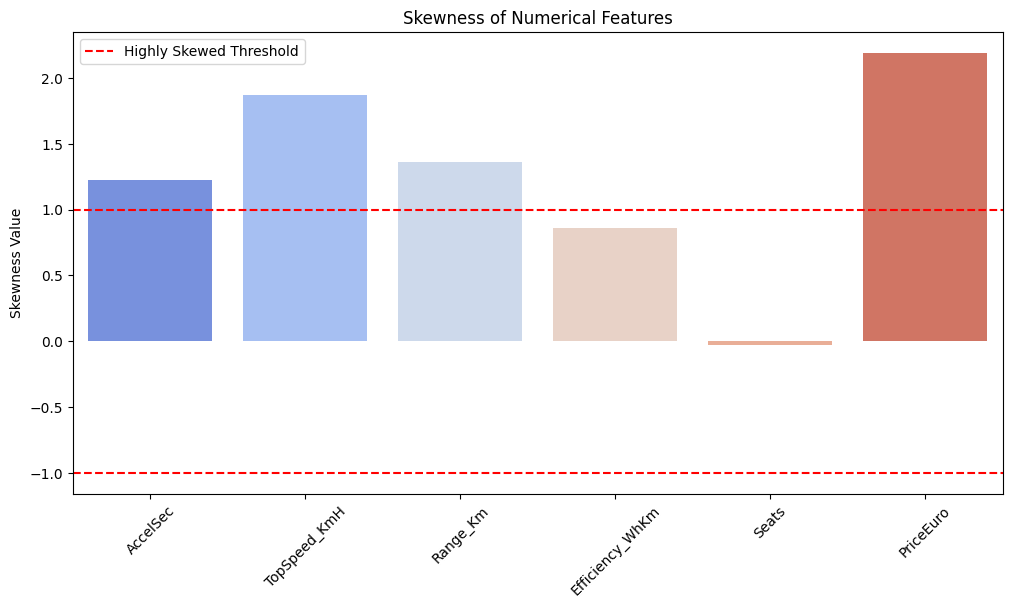

In [30]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Compute skewness
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
skew_values = df[numerical_cols].apply(skew, nan_policy='omit')

# Plot skewness as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=skew_values.index, y=skew_values.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.axhline(y=1, color='r', linestyle='--', label='Highly Skewed Threshold')
plt.axhline(y=-1, color='r', linestyle='--')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness Value')
plt.legend()
plt.show()


# Model Development

# Importing libraries 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [43]:
# Load dataset
df = pd.read_csv("/kaggle/input/datasetev/ElectricCarData_Clean.csv")  # Replace with actual dataset path

# Drop missing values
df.dropna(inplace=True)

# Select target variable
target = "PriceEuro"

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from feature columns
numerical_cols.remove(target)


# Transforming Data

In [44]:
# Define transformers for numerical and categorical columns
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


# Making Target variable

In [37]:
# Define target variable (Electric Vehicle Price)
target = "PriceEuro" 

# Define features (X) and target (y)
X = df.drop(columns=[target]) 
y = df[target] 


In [40]:
df.columns = df.columns.str.strip()  
df.columns = df.columns.str.replace(" ", "_")  

print("Column names:", df.columns)

target = "PriceEuro"  

if target not in df.columns:
    raise KeyError(f"Column '{target}' not found! Available columns: {df.columns}")

missing_values = df[target].isnull().sum()
print(f"Missing values in {target}: {missing_values}")

df.dropna(subset=[target], inplace=True)

X = df.drop(columns=[target])
y = df[target]

print("Data successfully cleaned and ready for modeling!")


Column names: Index(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
       'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro'],
      dtype='object')
Missing values in PriceEuro: 0
Data successfully cleaned and ready for modeling!


In [45]:
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AccelSec', 'TopSpeed_KmH',
                                                   'Range_Km',
                                                   'Efficiency_WhKm',
                                                   'Seats']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Brand', 'Model',
                                                   'FastCharge_KmH',
                                                   'RapidCharge', 'PowerTrain',
                                                   'PlugType', 'BodyStyle',
                                                   'Segment'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [47]:
# Predict on test data
y_pred = pipeline.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")


Mean Absolute Error (MAE): 6490.73
Mean Squared Error (MSE): 88196666.99
Root Mean Squared Error (RMSE): 9391.31
R-squared (R2 Score): 0.89


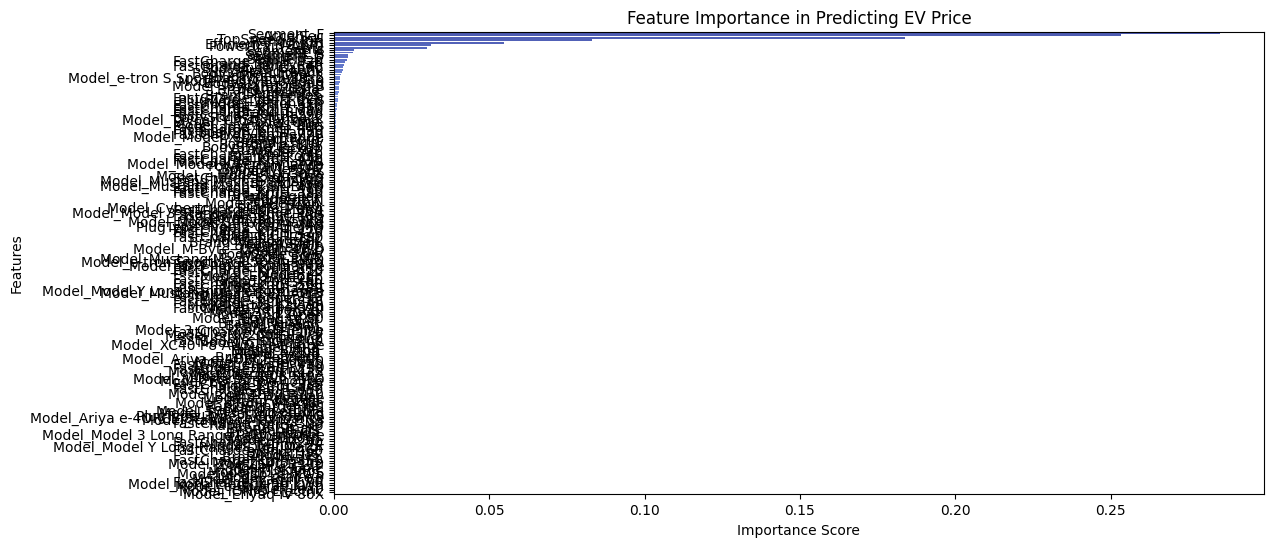

In [48]:
# Extract feature importance
feature_importance = model.feature_importances_

# Get feature names from preprocessing pipeline
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

# Create DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp_df['Importance'], y=feat_imp_df['Feature'], palette="coolwarm")
plt.title("Feature Importance in Predicting EV Price")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
